In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import math

import matplotlib.pyplot as plt

In [2]:

# Load the CSV file into a DataFrame
df = pd.read_csv('PCS_TEST_DETERMINSTIC.csv')

# Change Arrical time to inter arrival time
df['Inter Arrival Time'] = df['Arrival time (sec)'].diff()
df.rename(columns=lambda x: x.strip(), inplace=True)

# Display the first few rows of the DataFrame
df.head()


,Arrival no,Arrival time (sec),Base station,Call duration (sec),velocity (km/h),Inter Arrival Time
0,1,0.000,18,76.134,125.934,NaN
1,2,0.068,7,159.056,95.511,0.068
2,3,0.559,6,179.465,127.757,0.491
3,4,0.625,14,163.108,134.311,0.066
4,5,1.345,2,95.054,112.272,0.720


In [3]:
# Remove the first 2 columns
temp_df = df.drop(df.columns[[0, 1]], axis=1)

# Calculate the correlation matrix
correlation_matrix = temp_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                     Base station  Call duration (sec)  velocity (km/h)  \
Base station             1.000000             0.002429         0.007216   
Call duration (sec)      0.002429             1.000000        -0.012497   
velocity (km/h)          0.007216            -0.012497         1.000000   
Inter Arrival Time      -0.011658             0.004122         0.014616   

                     Inter Arrival Time  
Base station                  -0.011658  
Call duration (sec)            0.004122  
velocity (km/h)                0.014616  
Inter Arrival Time             1.000000  


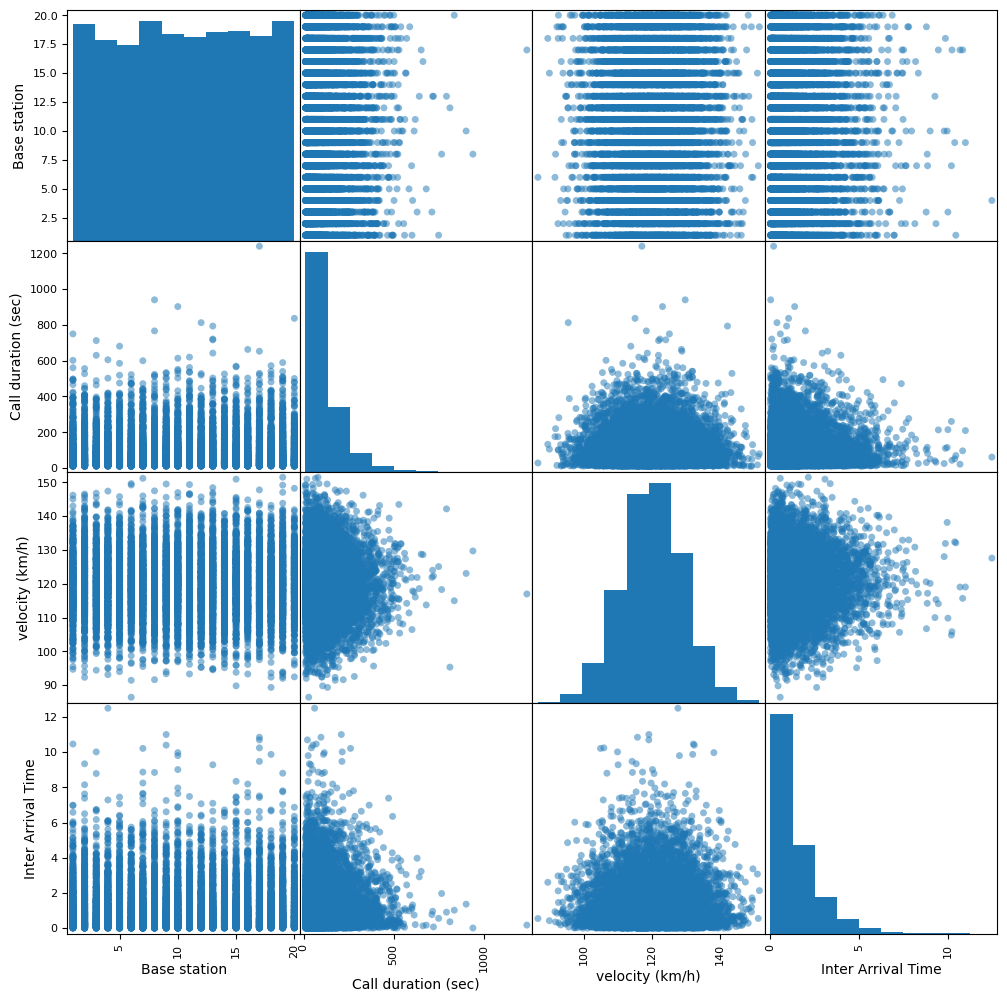

       Base station  Call duration (sec)  velocity (km/h)  Inter Arrival Time
count   10000.00000         10000.000000     10000.000000         9999.000000
mean       10.54220           109.835897       120.072095            1.369817
std         5.78662            99.138915         9.019056            1.343924
min         1.00000            10.004000        86.423000            0.000000
25%         6.00000            38.777750       113.892500            0.408000
50%        11.00000            79.937500       120.021500            0.962000
75%        16.00000           148.109500       126.188250            1.892000
max        20.00000          1239.836000       151.501000           12.499000


In [4]:
# Remove the first column (index 0) from the DataFrame
temp_df = df.drop(df.columns[[0, 1]], axis=1)

# Scatter plot to visualize the correlation between 'PCS' and 'PCS_1'
# Generate scatter plots for all pairs of columns in temp_df
pd.plotting.scatter_matrix(temp_df, figsize=(12, 12), diagonal='hist', alpha=0.5, s=len(temp_df) **0.5)
plt.show()

# Print basic statistics for each column in temp_df
print(temp_df.describe())

## Step 1: Data Independence
From the Correlation and scatter plots, we can observe that the variables are independent of each other.

## Step 2: Family of distributions
From the histograms, we can observe:
- Base Station is uniformly distributed
- Positiona in Base Station is uniformly distributed *
- Call Duration is exponentially distributed
- Velocity is normally distributed
- Inter Arrival Time is exponentially distributed

\* From the assignment, Assumtion (c) - "The position of the car initiating a call in a cell is uniformly distributed along the section of the highway covered by the base station."

### Call Duration Analysis

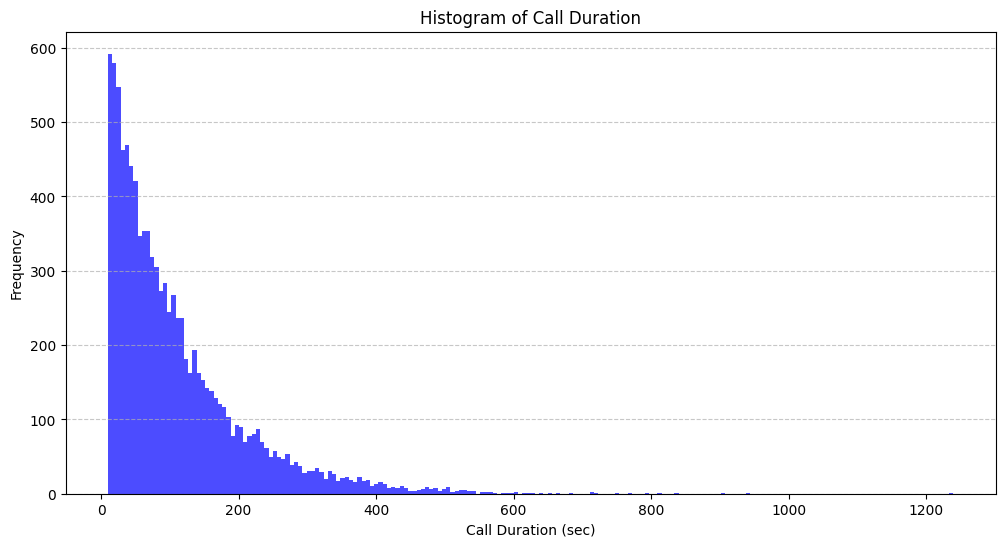

Bottom 10 Call durations:
5157    10.004
5610    10.033
1783    10.045
8638    10.047
4642    10.048
3723    10.049
400     10.064
6106    10.073
3041    10.079
1654    10.081
Name: Call duration (sec), dtype: float64


In [5]:
plt.figure(figsize=(12, 6))  # Set the figure size to make the plot wider
df['Call duration (sec)'].plot(kind='hist', bins=200, alpha=0.7, color='blue')
plt.title('Histogram of Call Duration')
plt.xlabel('Call Duration (sec)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Bottom 10 Call durations:")
print(temp_df['Call duration (sec)'].nsmallest(10))

#### Step 3: Call Duration - Exponential Distribution
We would use a shifted exponential distribution to model the call duration.

From slide deck 4, input modeling, slide 21, we would use

$$\underline{\text{Shifted  Exponential distribution}}\ X \sim \text{ShiftedExponential}(\lambda, x_0)$$

Where $\lambda$ is the rate parameter and $x_0$ is the shift parameter.

PDF:
$$f(x) = \begin{cases} \lambda e^{-\lambda (x - x_0)} & x \geq x_0 \\ 0 & x < x_0 \end{cases}$$

Maximum Likelihood Estimation (MLE) for the parameters $\lambda$ and $x_0$ is given by:
$$\hat{\lambda} = \frac{1}{\bar{x} - x_0}$$
$$\hat{x_0} = \min(x)$$

Where $\bar{x}$ is the sample mean and $x$ is the sample data.

\* for simplicity, we would assume $x_0 = \min(x)$ , $x_0 = 10.000$ as:
- $ 10.000 \approx \min(x) = 10.004$
- $x_0 \leq \min(x)$




In [6]:
x0_est_call_duration = 10
shifted_data = df['Call duration (sec)'] - x0_est_call_duration
sample_mean_call_duration = shifted_data.mean()
lambda_est_call_duration = 1/sample_mean_call_duration
print("Sample mean:", sample_mean_call_duration)
print("Lambda (1/sample mean):", lambda_est_call_duration)

Sample mean: 99.8358973
Lambda (1/sample mean): 0.010016437243961146


From this, we will selected
$$ \hat{\lambda} = 0.010016437243961146$$
$$\hat{x_0} = 10.000$$

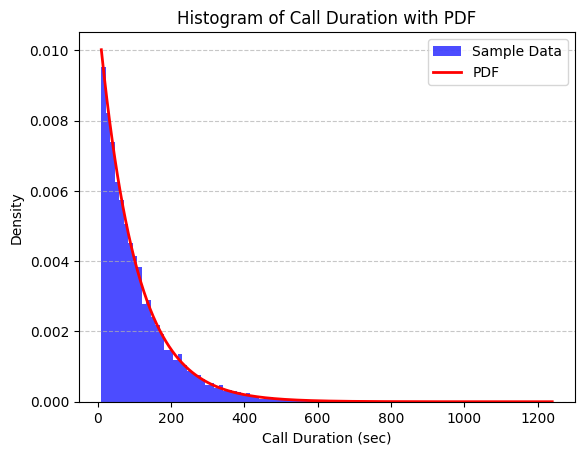

In [7]:
# x0_est_call_duration = 10 # Lower bound of the first bin
# lambda_est_call_duration = 0.010016437243961146 # Estimated parameter of the shifted exponential distribution

plt.hist(df["Call duration (sec)"], bins=100, alpha=0.7, color='blue', density=True, label='Sample Data')
x = np.linspace(df["Call duration (sec)"].min(), df["Call duration (sec)"].max(), 1000)
pdf = lambda_est_call_duration * np.exp(-lambda_est_call_duration * (x - x0_est_call_duration))
plt.plot(x, pdf, color='red', label='PDF', linewidth=2)
plt.title('Histogram of Call Duration with PDF')
plt.xlabel('Call Duration (sec)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### Step 4: Statistical goodness-of-fit test (Call Duration)
We would use chi-square test at 5% significance level to test the goodness of fit of the shifted exponential distribution.

We are using Chi-square test because there is a large sample size.

$H_0$: X conforms to f(x)
$H_1$: X does not conform to f(x)

since $n = 10000$, we would use $k = \sqrt{n} = 100$ bins.  
$$p_j = \frac{1}{k} = 0.01$$

In [8]:
n = 10000  # Sample size
k = math.sqrt(n)  # Number of bins
p_j = 1/k # Probability of each bin
n_pj = n * p_j  # Expected frequency in each bin

x0_est_call_duration = 10.04 # Lower bound of the first bin
# lambda_hat = 0.009104491560429032 # Estimated parameter of the shifted exponential distribution
lambda_hat = 0.01

bins_edges = x0_est_call_duration + stats.expon.ppf(np.linspace(0, 1, int(k)+1), scale=1/lambda_est_call_duration)


bins = pd.cut(temp_df['Call duration (sec)'], bins=bins_edges, right=False)
observed_counts = bins.value_counts().sort_index()
bin_df = pd.DataFrame(observed_counts).reset_index()
bin_df.rename(columns={'index': 'Class Interval', 'Call duration (sec)': 'n_j'}, inplace=True)
bin_df['n_pj'] = n_pj  # Expected frequency in each bin
bin_df["(Nj-npj)^2/npj"] = ((bin_df["n_j"] - n_pj) ** 2) / n_pj

print(bin_df)

chi_stat  = bin_df["(Nj-npj)^2/npj"].sum()
print("Chi-square statistic:", chi_stat )

degrees_of_freedom = k - 2 - 1  # Number of bins - number of parameters estimated - 1
print("Degrees of freedom:", degrees_of_freedom)

# p_value = 1 - stats.chi2.cdf(chi_stat, degrees_of_freedom)

alpha = 0.05  # Significance level
critical_value = stats.chi2.ppf(1 - alpha, degrees_of_freedom)
print("Critical value:", critical_value)
# Compare the chi-square statistic with the critical value
if chi_stat > critical_value:
    print("Reject the null hypothesis: The data does not conform to the shifted exponential distribution.")

else:
    print("Fail to reject the null hypothesis: The data conforms to the shifted exponential distribution.")

        Class Interval  n_j   n_pj  (Nj-npj)^2/npj
0      [10.04, 11.043)   86  100.0            1.96
1     [11.043, 12.057)   95  100.0            0.25
2     [12.057, 13.081)  109  100.0            0.81
3     [13.081, 14.116)   96  100.0            0.16
4     [14.116, 15.161)  112  100.0            1.44
..                 ...  ...    ...             ...
95  [309.122, 331.399)  100  100.0            0.00
96   [331.399, 360.12)  107  100.0            0.49
97     [360.12, 400.6)  113  100.0            1.69
98    [400.6, 469.801)   94  100.0            0.36
99      [469.801, inf)   93  100.0            0.49

[100 rows x 4 columns]
Chi-square statistic: 93.01999999999998
Degrees of freedom: 97.0
Critical value: 120.98964369660958
Fail to reject the null hypothesis: The data conforms to the shifted exponential distribution.


### Call Duration Analysis

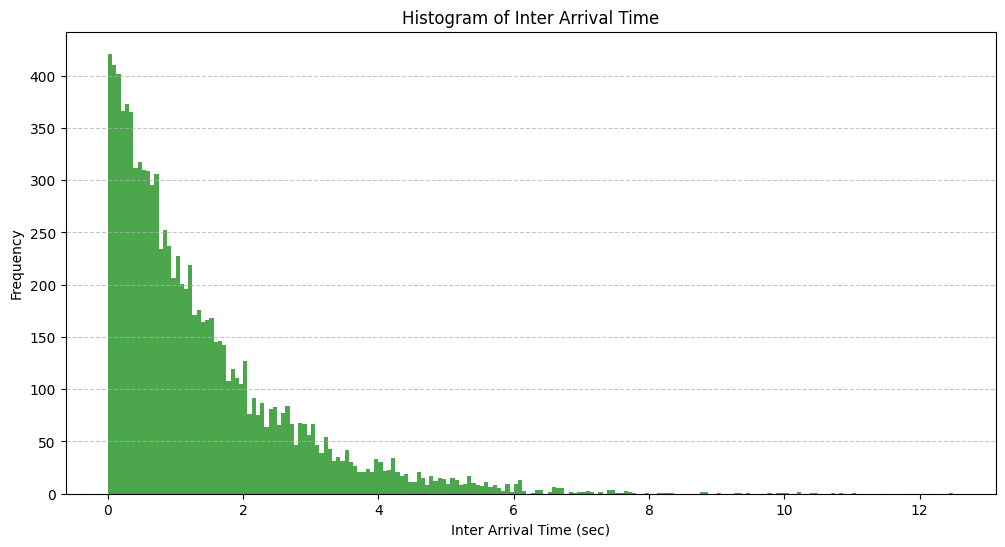

In [9]:
plt.figure(figsize=(12, 6))  # Set the figure size
df['Inter Arrival Time'].plot(kind='hist', bins=200, alpha=0.7, color='green')
plt.title('Histogram of Inter Arrival Time')
plt.xlabel('Inter Arrival Time (sec)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### Step 3: Inter Arrival Time - Exponential Distribution
We would use a exponential distribution to model the inter arrival time.

From slide deck 4, input modeling, slide 21, we would use

$$ \underline{\text{Exponential distribution}}\ X \sim \text{ShiftedExponential}(\lambda)$$

Where $\lambda$ is the rate parameter

PDF:
$$f(x) = \lambda e^{-\lambda x}  \\ 0 $$

Maximum Likelihood Estimation (MLE) for the parameters $\lambda$ and $x_0$ is given by:
$$\hat{\lambda} = \frac{1}{\bar{x}}$$

Where $\bar{x}$ is the sample mean and $x$ is the sample data.

#### Step 4: Statistical goodness-of-fit test (Inter Arrival Time)
We would use chi-square test at 5% significance level to test the goodness of fit of the shifted exponential distribution.

Mean Inter Arrival Time: 1.3698168816881688
Lambda (1/Mean Inter Arrival Time): 0.730024584576294


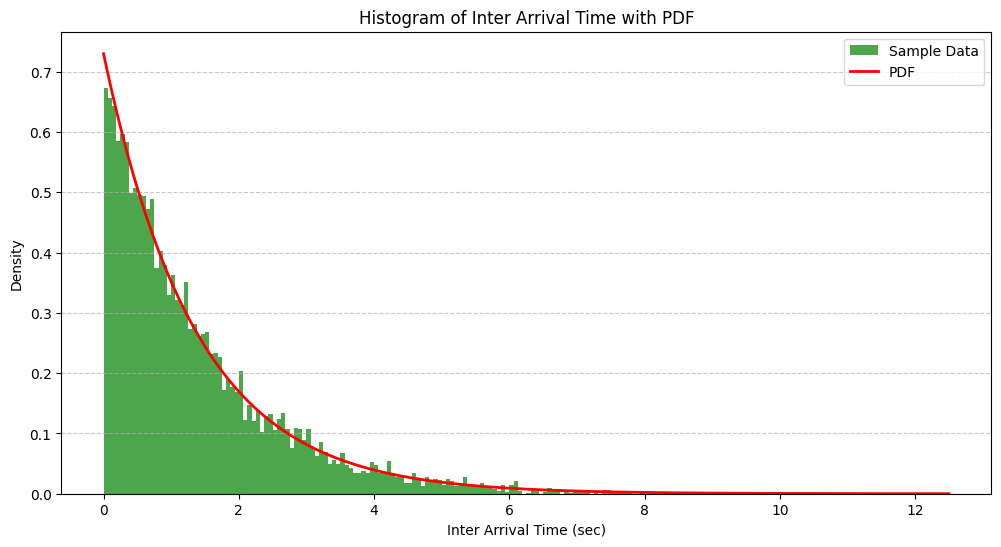

      Class Interval  n_j   n_pj  (Nj-npj)^2/npj
0      [0.0, 0.0138)   96  100.0            0.16
1   [0.0138, 0.0277)   94  100.0            0.36
2   [0.0277, 0.0417)   91  100.0            0.81
3   [0.0417, 0.0559)   98  100.0            0.04
4   [0.0559, 0.0703)  103  100.0            0.09
..               ...  ...    ...             ...
95    [4.104, 4.409)  114  100.0            1.96
96    [4.409, 4.803)   89  100.0            1.21
97    [4.803, 5.359)  111  100.0            1.21
98    [5.359, 6.308)   98  100.0            0.04
99      [6.308, inf)   81  100.0            3.61

[100 rows x 4 columns]
Chi-square statistic for Inter Arrival Time: 110.53
Degrees of freedom for Inter Arrival Time: 98.0
Critical value for Inter Arrival Time: 122.10773460981942
Fail to reject the null hypothesis: The inter-arrival times conform to the exponential distribution.


In [10]:
# Calculate the mean of the inter-arrival times
mean_inter_arrival_time = df['Inter Arrival Time'].mean()
lambda_inter_arrival = 1 / mean_inter_arrival_time
print("Mean Inter Arrival Time:", mean_inter_arrival_time)
print("Lambda (1/Mean Inter Arrival Time):", lambda_inter_arrival)

plt.figure(figsize=(12, 6))  # Set the figure size
df['Inter Arrival Time'].plot(kind='hist', bins=200, alpha=0.7, color='green', density=True, label='Sample Data')
x = np.linspace(df['Inter Arrival Time'].min(), df['Inter Arrival Time'].max(), 1000)
pdf = lambda_inter_arrival * np.exp(-lambda_inter_arrival * x)
plt.plot(x, pdf, color='red', label='PDF', linewidth=2)
plt.title('Histogram of Inter Arrival Time with PDF')
plt.xlabel('Inter Arrival Time (sec)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate the number of bins for the histogram
n_inter_arrival = len(df['Inter Arrival Time'])
k_inter_arrival = math.sqrt(n_inter_arrival)  # Number of bins
p_j_inter_arrival = 1 / k_inter_arrival  # Probability of each bin
n_pj_inter_arrival = n_inter_arrival * p_j_inter_arrival  # Expected frequency in each bin

bins_edges_inter_arrival = stats.expon.ppf(np.linspace(0, 1, int(k_inter_arrival) + 1), scale=1/lambda_inter_arrival)
bins_inter_arrival = pd.cut(df['Inter Arrival Time'], bins=bins_edges_inter_arrival, right=False)
observed_counts_inter_arrival = bins_inter_arrival.value_counts().sort_index()

bin_df_inter_arrival = pd.DataFrame(observed_counts_inter_arrival).reset_index()
bin_df_inter_arrival.rename(columns={'index': 'Class Interval', 'Inter Arrival Time': 'n_j'}, inplace=True)
bin_df_inter_arrival['n_pj'] = n_pj_inter_arrival  # Expected frequency in each bin
bin_df_inter_arrival["(Nj-npj)^2/npj"] = ((bin_df_inter_arrival["n_j"] - n_pj_inter_arrival) ** 2) / n_pj_inter_arrival

print(bin_df_inter_arrival)

chi_stat_inter_arrival = bin_df_inter_arrival["(Nj-npj)^2/npj"].sum()
print("Chi-square statistic for Inter Arrival Time:", chi_stat_inter_arrival)
degrees_of_freedom_inter_arrival = k_inter_arrival - 1 - 1  # Number of bins - number of parameters estimated - 1
print("Degrees of freedom for Inter Arrival Time:", degrees_of_freedom_inter_arrival)

# p_value_inter_arrival = 1 - stats.chi2.cdf(chi_stat_inter_arrival, degrees_of_freedom_inter_arrival)
alpha_inter_arrival = 0.05  # Significance level
critical_value_inter_arrival = stats.chi2.ppf(1 - alpha_inter_arrival, degrees_of_freedom_inter_arrival)
print("Critical value for Inter Arrival Time:", critical_value_inter_arrival)

# Compare the chi-square statistic with the critical value

if chi_stat_inter_arrival > critical_value_inter_arrival:
    print("Reject the null hypothesis: The inter-arrival times do not conform to the exponential distribution.")
else:
    print("Fail to reject the null hypothesis: The inter-arrival times conform to the exponential distribution.")


### Velocity Analysis
#### Step 3: Estimation of the parameters of a probability distribution (Velocity)

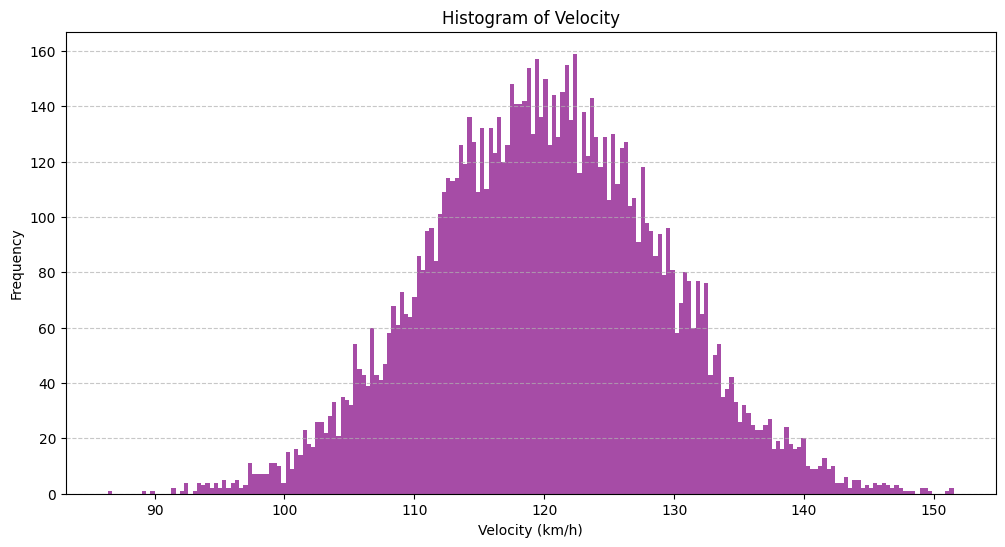

In [11]:
plt.figure(figsize=(12, 6))  # Set the figure size to make the plot wider
temp_df['velocity (km/h)'].plot(kind='hist', bins=200, alpha=0.7, color='purple')
plt.title('Histogram of Velocity')
plt.xlabel('Velocity (km/h)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Step 3: Velocity - Normal Distribution
We would use a normal distribution to model the velocity.

From slide deck 4, input modeling, slide 21, we would use

$$\underline{\text{Normal distribution}}\ X \sim N(\mu, \sigma^2)$$

Where $\mu$ is the mean and $\sigma^2$ is the variance.

PDF:
$$f(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

Maximum Likelihood Estimation (MLE) for the parameters $\mu$ and $\sigma^2$ is given by:

$$\hat{\mu} = \hat{X}(n), \quad \sigma^2 = S^2$$

#### Step 4: Statistical goodness-of-fit test (Velocity)
We would use chi-square test at 5% significance level to test the goodness of fit of the normal distribution.

Estimated Mean Velocity: 120.0720949
Estimated Std Dev Velocity: 9.01905562259854


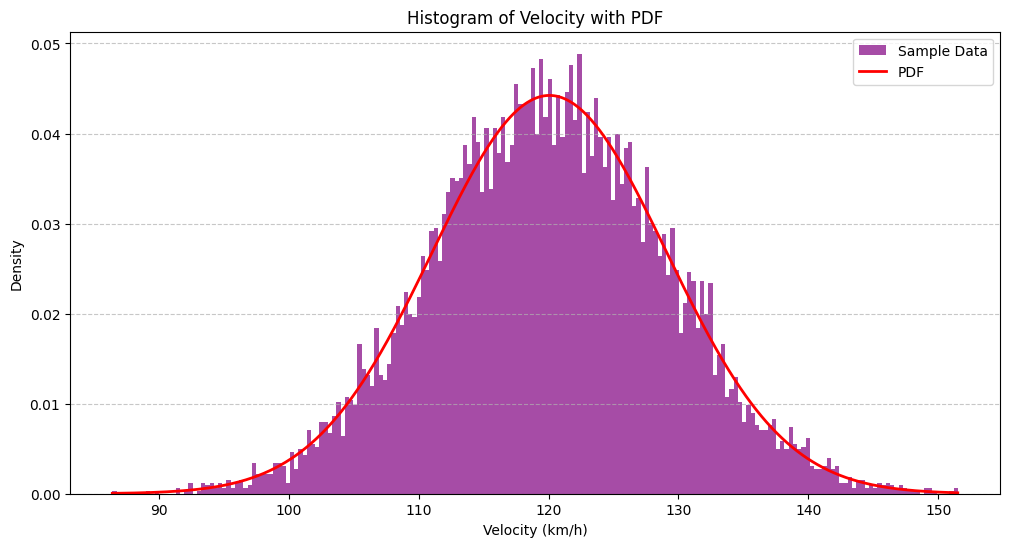

        Class Interval  n_j   n_pj  (Nj-npj)^2/npj
0       [-inf, 99.091)  101  100.0            0.01
1    [99.091, 101.549)   86  100.0            1.96
2   [101.549, 103.109)  110  100.0            1.00
3   [103.109, 104.283)   95  100.0            0.25
4   [104.283, 105.237)  100  100.0            0.00
..                 ...  ...    ...             ...
95  [134.907, 135.862)   86  100.0            1.96
96  [135.862, 137.035)   84  100.0            2.56
97  [137.035, 138.595)  100  100.0            0.00
98  [138.595, 141.054)  113  100.0            1.69
99      [141.054, inf)  107  100.0            0.49

[100 rows x 4 columns]
Chi-square statistic for Velocity: 96.05999999999999
Degrees of freedom for Velocity: 97.0
Critical value for Velocity: 120.98964369660958
Fail to reject the null hypothesis: The velocity data conforms to the normal distribution.


In [12]:
mu_est_velocity = temp_df['velocity (km/h)'].mean()
sigma_est_velocity = temp_df['velocity (km/h)'].std()
print("Estimated Mean Velocity:", mu_est_velocity)
print("Estimated Std Dev Velocity:", sigma_est_velocity)

plt.figure(figsize=(12, 6))  # Set the figure size
x = np.linspace(temp_df['velocity (km/h)'].min(), temp_df['velocity (km/h)'].max(), 1000)
pdf = (1 / (sigma_est_velocity * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_est_velocity) / sigma_est_velocity) ** 2)
temp_df['velocity (km/h)'].plot(kind='hist', bins=200, alpha=0.7, color='purple', density=True, label='Sample Data')
plt.plot(x, pdf, color='red', label='PDF', linewidth=2)
plt.title('Histogram of Velocity with PDF')
plt.xlabel('Velocity (km/h)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Perform a goodness-of-fit test for velocity data
n_velocity = len(temp_df['velocity (km/h)'])
k_velocity = math.sqrt(n_velocity)  # Number of bins
p_j_velocity = 1 / k_velocity  # Probability of each bin
n_pj_velocity = n_velocity * p_j_velocity  # Expected frequency in each bin

bins_edges_velocity = stats.norm.ppf(np.linspace(0, 1, int(k_velocity) + 1), loc=mu_est_velocity, scale=sigma_est_velocity)
bins_velocity = pd.cut(temp_df['velocity (km/h)'], bins=bins_edges_velocity, right=False)
observed_counts_velocity = bins_velocity.value_counts().sort_index()

bin_df_velocity = pd.DataFrame(observed_counts_velocity).reset_index()
bin_df_velocity.rename(columns={'index': 'Class Interval', 'velocity (km/h)': 'n_j'}, inplace=True)
bin_df_velocity['n_pj'] = n_pj_velocity  # Expected frequency in each bin
bin_df_velocity["(Nj-npj)^2/npj"] = ((bin_df_velocity["n_j"] - n_pj_velocity) ** 2) / n_pj_velocity

print(bin_df_velocity)

chi_stat_velocity = bin_df_velocity["(Nj-npj)^2/npj"].sum()
print("Chi-square statistic for Velocity:", chi_stat_velocity)
degrees_of_freedom_velocity = k_velocity - 2 - 1  # Number of bins - number of parameters estimated - 1
print("Degrees of freedom for Velocity:", degrees_of_freedom_velocity)

alpha_velocity = 0.05  # Significance level
critical_value_velocity = stats.chi2.ppf(1 - alpha_velocity, degrees_of_freedom_velocity)
print("Critical value for Velocity:", critical_value_velocity)

# Compare the chi-square statistic with the critical value
if chi_stat_velocity > critical_value_velocity:
    print("Reject the null hypothesis: The velocity data does not conform to the normal distribution.")
else:
    print("Fail to reject the null hypothesis: The velocity data conforms to the normal distribution.")

### Base Station Analysis

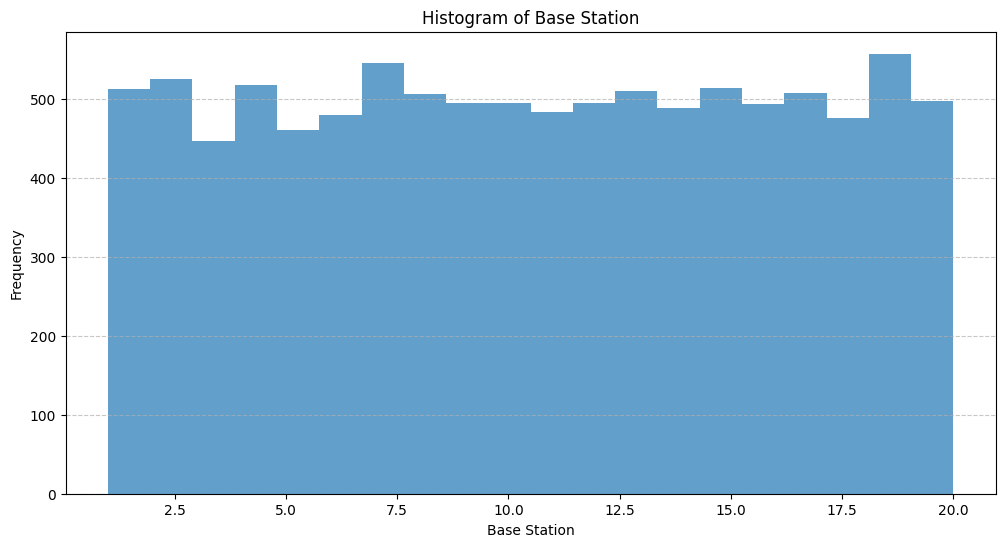

In [14]:
plt.figure(figsize=(12, 6))  # Set the figure size
temp_df['Base station'].plot(kind='hist', bins=20, alpha=0.7)
plt.title('Histogram of Base Station')
plt.xlabel('Base Station')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Step 3: Estimation of the parameters of a probability distribution (Base Station)
#### Step 3: Base Station - Uniform Distribution
We would use a uniform discrete distribution to model the base station.

1 to 20

PDF:
$$f(x) = \frac{1}{20}$$

There are no estimator as the start and end points are known.
#### Step 4: Statistical goodness-of-fit test (Base Station)


In [ ]:
# Define the range of the uniform distribution
x_min_uniform = 1
x_max_uniform = 20

# Calculate the expected frequency for each bin
n_uniform = len(temp_df['Base station'])  # Total number of samples
k_uniform = x_max_uniform - x_min_uniform + 1  # Number of bins (discrete uniform distribution)
p_j_uniform = 1 / k_uniform  # Probability of each bin
n_pj_uniform = n_uniform * p_j_uniform  # Expected frequency in each bin

# Count the observed frequency for each bin
observed_counts_uniform = temp_df['Base station'].value_counts().sort_index()

# Create a DataFrame for observed and expected frequencies
bin_df_uniform = pd.DataFrame({
    'Class Interval': observed_counts_uniform.index,
    'n_j': observed_counts_uniform.values,
    'n_pj': [n_pj_uniform] * len(observed_counts_uniform)
})
bin_df_uniform["(Nj-npj)^2/npj"] = ((bin_df_uniform["n_j"] - bin_df_uniform["n_pj"]) ** 2) / bin_df_uniform["n_pj"]

# Calculate the chi-square statistic
chi_stat_uniform = bin_df_uniform["(Nj-npj)^2/npj"].sum()
print("Chi-square statistic for Uniform Distribution:", chi_stat_uniform)

# Degrees of freedom
degrees_of_freedom_uniform = k_uniform - 1  # Number of bins - 1
print("Degrees of freedom for Uniform Distribution:", degrees_of_freedom_uniform)

# Critical value at 5% significance level
alpha_uniform = 0.05
critical_value_uniform = stats.chi2.ppf(1 - alpha_uniform, degrees_of_freedom_uniform)
print("Critical value for Uniform Distribution:", critical_value_uniform)

# Compare the chi-square statistic with the critical value
if chi_stat_uniform > critical_value_uniform:
    print("Reject the null hypothesis: The data does not conform to the uniform distribution.")
else:
    print("Fail to reject the null hypothesis: The data conforms to the uniform distribution.")

Chi-square statistic for Uniform Distribution: 25.656000000000002
Degrees of freedom for Uniform Distribution: 19
Critical value for Uniform Distribution: 30.14352720564616
Fail to reject the null hypothesis: The data conforms to the uniform distribution.


# Conclusion
1. Call Duration, Inter Arrival Time, Velocity and Base Station are independent of each other
2. Call Duration is shifted exponentially distributed with $$\hat{\lambda} = 0.010016437243961146$$ and $$\hat{x_0} = 10.000$$
3. Inter Arrival Time is exponentially distributed with $$\hat{\lambda} = 1.3698168816881688$$
4. Velocity is normally distributed with $$\hat{\mu} = 120.0720949$$ and $$\sigma^2 = 9.01905562259854$$
5. Base Station is uniformly distributed with $$f(x) = \frac{1}{20}$$
6. The goodness of fit test for Call Duration, Inter Arrival Time, Velocity and Base Station are all accepted at 5% significance level